In [1]:
import librosa
import numpy as np
import pandas as pd
import torch
import os
import sys

sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import ASC_datasets
import audio_utils as au
import models

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
TUT_DF = pd.read_csv(ASC_datasets.TUT_TEST_CSV)
TUT_scenes = TUT_DF['labels'].unique()
asc_model = models.Cnn_9layers_AvgPooling(10, 'logsoftmax')
asc_model.load_state_dict(torch.load('../ASC_AED_JoinTask/ASC_TUT18_Cnn9_64mel_10epochs.pt'))

<All keys matched successfully>

In [26]:
SAMPLE_RATE = 32000
WINDOW_SIZE = 1024
HOP_SIZE = 500
MEL_BINS = 64
FMIN = 50
FMAX = 16000
N_FFT = 1024

fft_freq = librosa.fft_frequencies(sr=SAMPLE_RATE, n_fft=N_FFT)
mel_freq = librosa.mel_frequencies(n_mels=MEL_BINS, fmax=FMAX)

def get_logMel(audio):
    log_mel = au.get_log_melSpectrogram(
        audio, sample_rate=SAMPLE_RATE, n_mels=MEL_BINS, n_fft=WINDOW_SIZE, hop_len=HOP_SIZE
    )
    return log_mel

# Ablate features according to index, and returns new audio
def ablate_features(index, audio):

    audio_stft = librosa.stft(audio, n_fft=N_FFT)
    low_index = index*4
    high_index = low_index+3
    l0 = fft_freq>=mel_freq[low_index]
    l1 = fft_freq<=mel_freq[high_index]

    for i in range(len(l0)):
        if l0[i] & l1[i]:
            audio_stft[i,:] = np.complex64(0+0j)

    y_new = librosa.istft(audio_stft, n_fft=N_FFT)
    return y_new


sample_file = os.path.join(TUT_AUD_DIR, TUT_DF['files'].iloc[1985])
audio = au.load_audio_from_file(sample_file, sample_rate=SAMPLE_RATE)
#TUT_scenes[torch.argmax(torch.sigmoid(asc_model(get_logMel(audio))))]

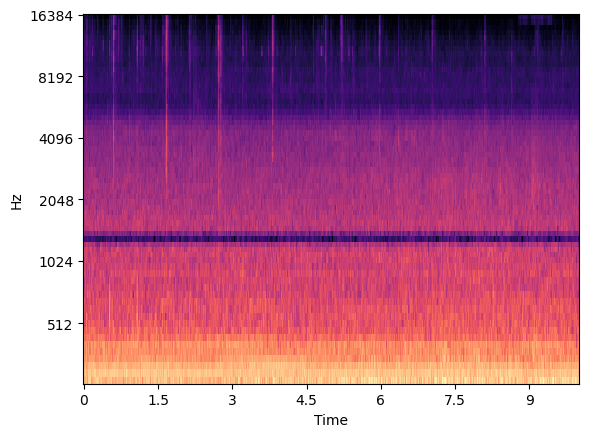

In [27]:
logmel = get_logMel(audio)
ablated = ablate_features(5, audio)
abl_log = get_logMel(ablated)

librosa.display.specshow(abl_log.squeeze().numpy(), sr=SAMPLE_RATE, x_axis='time', y_axis='mel', win_length=N_FFT, hop_length=HOP_SIZE, fmax=FMAX, fmin=FMIN)

In [5]:
device = 'cuda:0'
asc_model = asc_model.to(device)

In [103]:
scene_preds = []
ablated_feat_scene_preds = []

asc_model.eval()
# Scene Preds Loop
for i, row in TUT_DF.iterrows():
    
    org_aud_fname = (os.path.join(TUT_AUD_DIR, row['files']))
    audio = au.load_audio_from_file(org_aud_fname, sample_rate=SAMPLE_RATE)
    logmel = get_logMel(audio)
    with torch.inference_mode():
        pred = TUT_scenes[torch.argmax(torch.sigmoid(asc_model(logmel.to(device))))]
    scene_preds.append(pred)
    
    # Ablated Features Scene Preds Loop
    ablated_feat_scene_preds_list = []
    for j in range(16):
        ablated_audio = ablate_features(j, audio)
        ablated_logmel = get_logMel(ablated_audio)
        with torch.inference_mode():
            ablated_pred = TUT_scenes[torch.argmax(torch.sigmoid(asc_model(ablated_logmel.to(device))))]
        ablated_feat_scene_preds_list.append(ablated_pred)
    ablated_feat_scene_preds.append(ablated_feat_scene_preds_list)
        

In [123]:
TUT_DF['scene_preds'] = scene_preds
TUT_DF['ablated_scene_preds'] = ablated_feat_scene_preds
TUT_DF.to_csv('tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv', index=False)

In [7]:
# Calling the already existing csv file from the previously ran code above
csv_file = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv'
TUT_DF = pd.read_csv(csv_file)

In [8]:
from collections import defaultdict

true_indices_dict = defaultdict(dict)
false_indices_dict = defaultdict(dict)
scene_wise_true = {i:0 for i in TUT_scenes}
scene_wise_false = {i:0 for i in TUT_scenes}

# Creating a dictionary for ablated indices and to find important indices for scene predictions
for j in TUT_scenes:
    for i in range(16):
        true_indices_dict[j][i] = 0
        false_indices_dict[j][i] = 0

In [9]:
import ast
TUT_DF['ablated_scene_preds'] = TUT_DF['ablated_scene_preds'].apply(lambda x: ast.literal_eval(x))

In [10]:
# Focusing only on the indices of feat ablation
for i, row in TUT_DF.iterrows():
    ablated_preds = row['ablated_scene_preds']
    scene_wise_true[row['labels']] += (1 if row['labels'] == row['scene_preds'] else 0)
    scene_wise_false[row['labels']] += (1 if row['labels'] != row['scene_preds'] else 0)
    for j in range(len(ablated_preds)):
        # WE want to check if the earlier predictions are same as the ablated predictions
        if (row['labels'] == row['scene_preds']) and (ablated_preds[j] != row['labels']):
            true_indices_dict[row['labels']][j] += 1
        # We want to check if the earlier mispredictions are converted to true preds by ablation
        elif (row['labels'] != row['scene_preds']) and (ablated_preds[j] == row['labels']):
            false_indices_dict[row['labels']][j] += 1

In [11]:
# In order to normalise the values to 1
for scene in TUT_scenes:
    for i in range(16):
        true_indices_dict[scene][i] = true_indices_dict[scene][i]/scene_wise_true[scene]
        false_indices_dict[scene][i] = false_indices_dict[scene][i]/scene_wise_false[scene]

<Axes: >

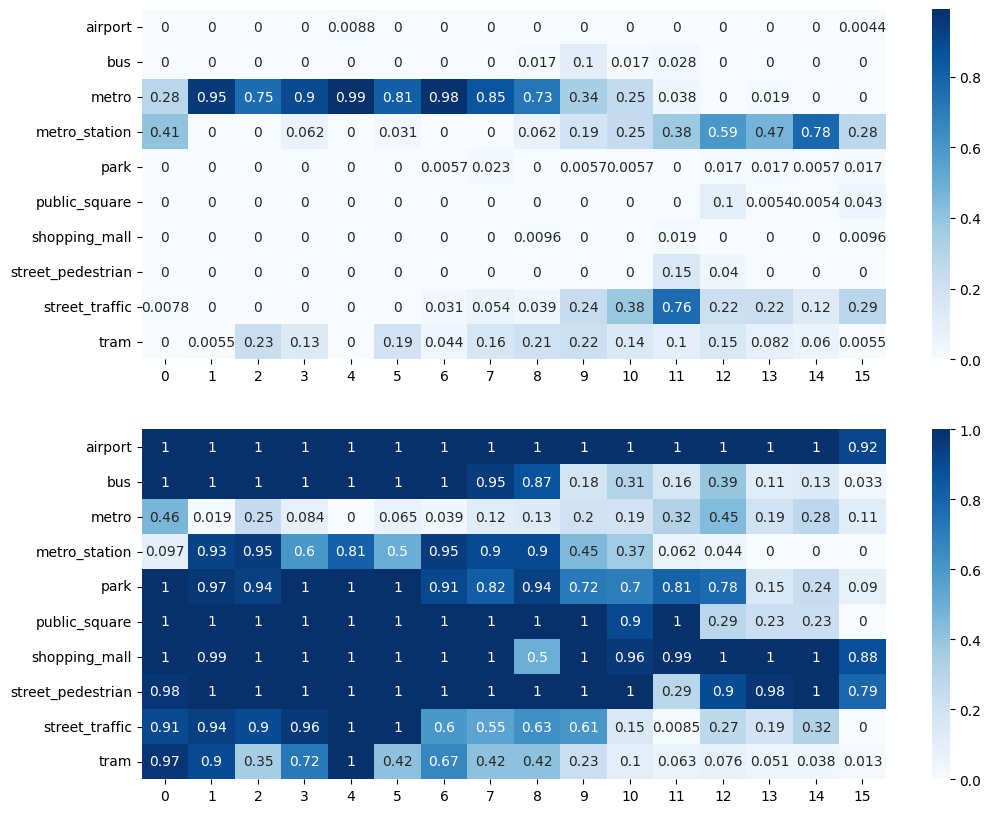

In [12]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
sns.heatmap(pd.DataFrame(false_indices_dict).transpose(), annot=True, cmap='Blues', yticklabels=TUT_scenes)
plt.subplot(2,1,2)
sns.heatmap(pd.DataFrame(true_indices_dict).transpose(), annot=True, cmap='Blues', yticklabels=TUT_scenes)

In [22]:
mimp_indices = defaultdict(dict)
count =0
for scene in TUT_scenes:
    mimp_indices[scene] = []
    for i in true_indices_dict[scene]:
        if true_indices_dict[scene][i] >= 0.45: 
            mimp_indices[scene].append(i)
            count += 1

In [30]:
TUT_selected = TUT_DF[TUT_DF['labels'] == TUT_DF['scene_preds']]


In [38]:
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.1:
            event_list.append(np.array(labels)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
GPU number: 4


In [41]:
# Loop for predicting audio tags for the original audio
audio_tags_org = []

for i, row in TUT_selected.iterrows():
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    audio_tags_org.append(get_panns_events_list(audio))

In [42]:
TUT_selected['audio_tags_org'] = audio_tags_org

/tmp/ipykernel_2958738/4112817551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TUT_selected['audio_tags_org'] = audio_tags_org


In [49]:
# Loop for predicting audio tags for the ablated audio
audio_tags_ablated = []

for i, row in TUT_selected.iterrows():
    ablated_tags_list = []
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    scene = row['scene_preds']
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    
    for i in mimp_indices[scene]:
        ablated = ablate_features(i, audio)
        ablated_tags_list.append(get_panns_events_list(ablated))

    audio_tags_ablated.append(ablated_tags_list)

TUT_selected['audio_tags_ablated'] = audio_tags_ablated

/tmp/ipykernel_2958738/2454917451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TUT_selected['audio_tags_ablated'] = audio_tags_ablated


In [51]:
TUT_selected.to_csv('tut_preds/Cnn9_64mel_tut_selected_ablated_tags.csv', index=False)

                   precision    recall  f1-score   support

          airport       0.81      0.14      0.24       265
              bus       0.47      0.25      0.33       242
            metro       0.30      0.59      0.40       261
    metro_station       0.21      0.88      0.34       259
             park       0.77      0.28      0.41       242
    public_square       0.79      0.14      0.24       216
    shopping_mall       0.73      0.63      0.67       279
street_pedestrian       0.55      0.19      0.29       247
   street_traffic       0.91      0.48      0.62       246
             tram       0.48      0.30      0.37       261

         accuracy                           0.40      2518
        macro avg       0.60      0.39      0.39      2518
     weighted avg       0.60      0.40      0.40      2518



<Axes: >

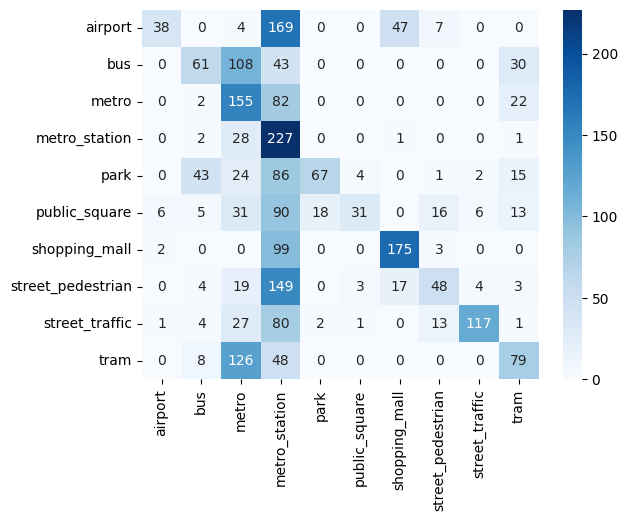

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(TUT_DF['labels'], TUT_DF['scene_preds'], target_names=TUT_scenes))
cm = confusion_matrix(TUT_DF['labels'], TUT_DF['scene_preds'], labels=TUT_scenes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=TUT_scenes, yticklabels=TUT_scenes)

In [112]:
indices_dict = defaultdict(dict)
for i in range(16):
    for scenes in TUT_scenes:
        indices_dict[i][scenes]=0

for i, row in TUT_DF.iterrows():
    ablated_ = row['ablated_scene_preds']

    for j in range(len(ablated_)):
        indices_dict[j][ablated_[j]] += 1

In [122]:
len(TUT_DF)*16

40288

<Axes: >

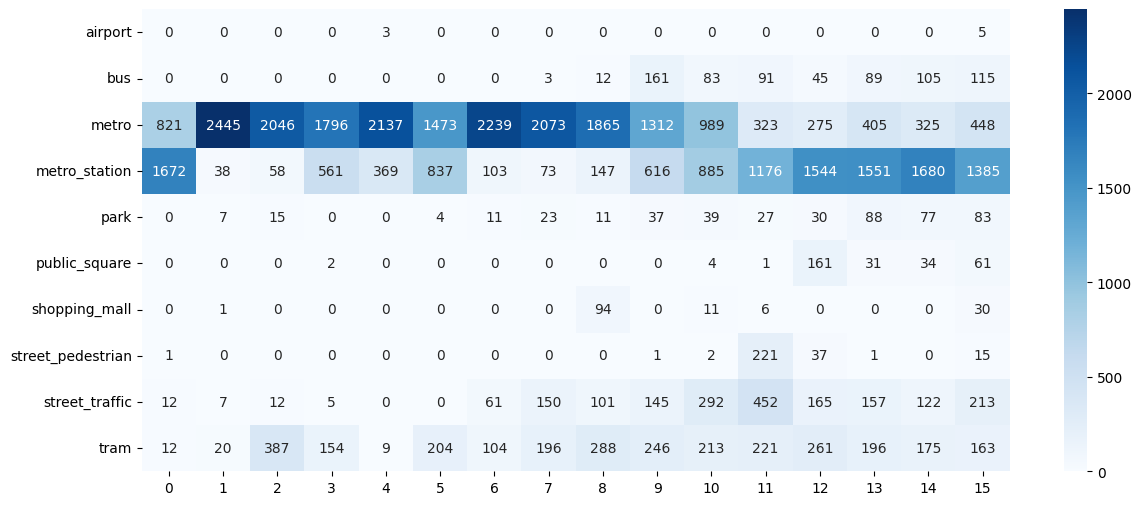

In [120]:
plt.figure(figsize=(14, 6))
sns.heatmap(pd.DataFrame(indices_dict), fmt='d', annot=True, cmap='Blues', yticklabels=TUT_scenes)